<a href="https://colab.research.google.com/github/ssubin29/KaggleStruggle/blob/main/StateFarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle API 연동

In [ ]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir dataset
!unzip /content/drive/MyDrive/Colab/KaggleStruggle/dataset/statefarm/state-farm-distracted-driver-detection.zip -d /content/dataset

# Import module

In [ ]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

#!pip uninstall scikit-learn
#!pip install scikit-learn==0.20.1
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D

In [ ]:
dataset = pd.read_csv('/content/dataset/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10

# Color type: 1 - grey, 3 - rgb

# cv2로 image를 읽고 64x64로 resize
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #gray로 읽기
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR) #color로 읽기
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) #64x64로 resize
    return img

# c0~c9 image load (c0~9 become labels(after one-hot encoding) become Y, image(after one-hot encoding) become train_X)
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print(f'classed {classed}')
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content/dataset', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    print(train_labels)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    # to_categorical은 one-hot encoding 실행 10진 정수 형식을 특수한 2진 바이너리 형식으로 변경 
    # 10 크기의 배열에 labels 위치에만 1

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # train/test split for practice
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/dataset', 'imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

In [ ]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

classed 0
Loading directory c0


 10%|█         | 1/10 [00:04<00:41,  4.58s/it]

classed 1
Loading directory c1


 20%|██        | 2/10 [00:08<00:34,  4.34s/it]

classed 2
Loading directory c2


 30%|███       | 3/10 [00:12<00:29,  4.29s/it]

classed 3
Loading directory c3


 40%|████      | 4/10 [00:17<00:25,  4.29s/it]

classed 4
Loading directory c4


 50%|█████     | 5/10 [00:21<00:21,  4.28s/it]

classed 5
Loading directory c5


 60%|██████    | 6/10 [00:25<00:17,  4.27s/it]

classed 6
Loading directory c6


 70%|███████   | 7/10 [00:30<00:12,  4.27s/it]

classed 7
Loading directory c7


 80%|████████  | 8/10 [00:33<00:08,  4.10s/it]

classed 8
Loading directory c8


 90%|█████████ | 9/10 [00:37<00:03,  3.90s/it]

classed 9
Loading directory c9


100%|██████████| 10/10 [00:41<00:00,  4.12s/it]

Data Loaded in 41.197044372558594 second
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<02:54, 454.83it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


# Data Statistics

In [ ]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("/content/dataset/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('/content/dataset', 'imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


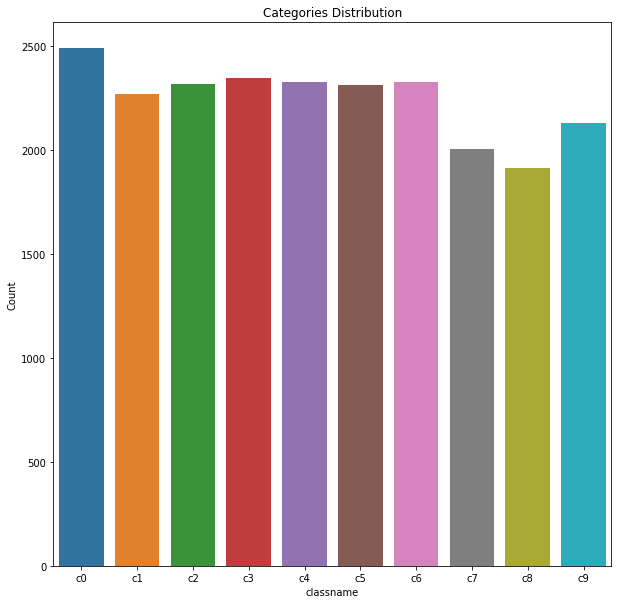

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

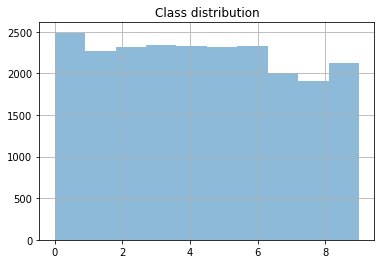

In [ ]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# image overview

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

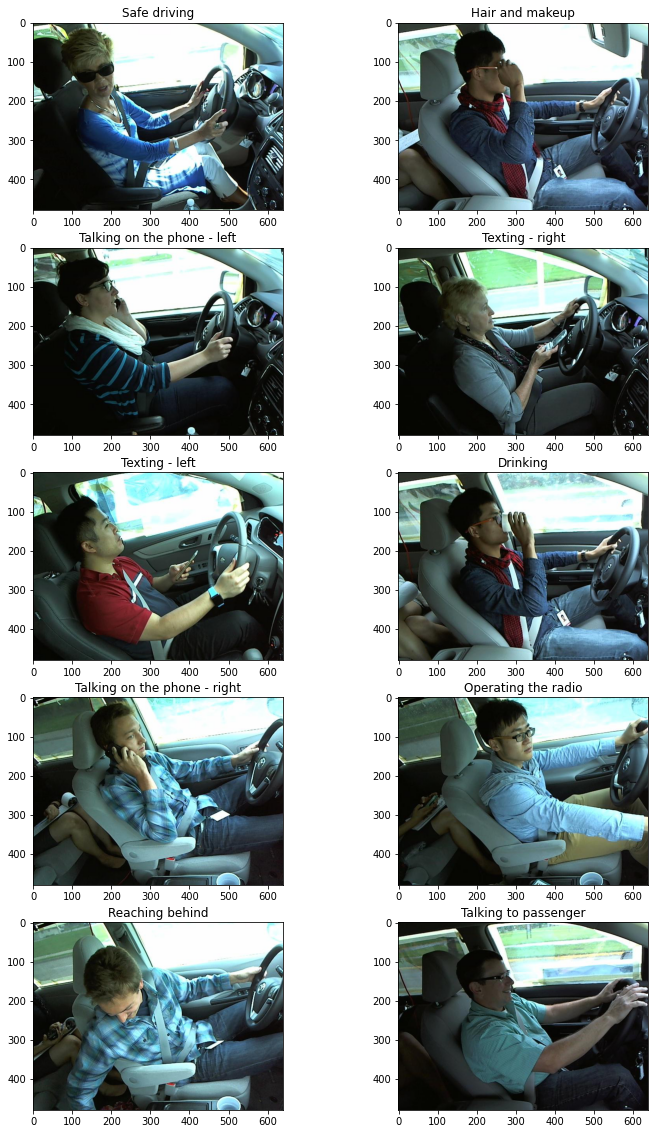

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/dataset/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
      for i, file in enumerate(os.listdir(BASE_URL + directory)):
          if i == 1:
              break
          else:
              fig = plt.subplot(5, 2, image_count)
              image_count += 1
              image = mpimg.imread(BASE_URL + directory + '/' + file)
              # imread 함수를 통해 jpg 불러오기
              plt.imshow(image)
              plt.title(activity_map[directory])

In [ ]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

# Create banilla CNN model

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [ ]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [ ]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 256)        0

In [ ]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=3)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.38073, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10

Epoch 00002: val_loss improved from 0.38073 to 0.09905, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.09905
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.09905
Epoch 00004: early stopping


In [ ]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

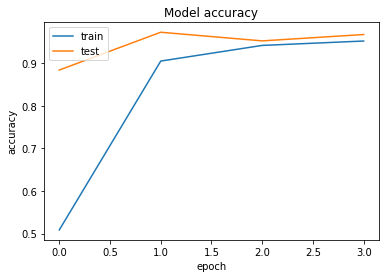

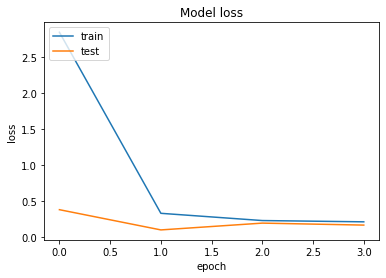

In [ ]:
plot_train_history(history_v1)

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)

    
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format('c{}'.format(np.argmax(y_prediction))))
    # np.argmax 다차원 배열의 경우에 차원에 따라 가장 큰 값의 인덱스를 반환 -> c0~9중 가장 큰 값이 바로 예측값이 되는 것
    
    plt.show()

In [ ]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 2s 11ms/step - loss: 0.0990 - accuracy: 0.9728
Score:  [0.09904857724905014, 0.972798228263855]


1/1 [==============================] - 0s 201ms/step
Y prediction: [[1.5669512e-02 1.1408375e-06 6.1074738e-06 1.3858603e-01 4.8219621e-02
  7.9438341e-01 6.7100285e-05 9.2346971e-05 3.7312671e-04 2.6016429e-03]]
Predicted: c5


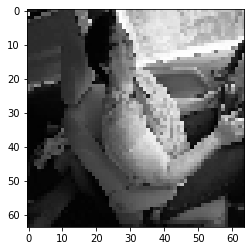

In [ ]:
plot_test_class(model_v1, test_files, 30)

In [ ]:
submission = pd.read_csv("/content/dataset/sample_submission.csv")
submission[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']] = submission[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']].astype(int)
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0,0,0,0,0,0,0,0,0,0
1,img_10.jpg,0,0,0,0,0,0,0,0,0,0
2,img_100.jpg,0,0,0,0,0,0,0,0,0,0
3,img_1000.jpg,0,0,0,0,0,0,0,0,0,0
4,img_100000.jpg,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission.shape[0]

79726

In [ ]:
nb_test_samples = 819200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

100%|██████████| 79726/79726 [02:47<00:00, 475.15it/s]


Test shape: (79726, 64, 64, 1)
79726 Test samples


In [ ]:
test_files.shape[0]

79726

In [ ]:
def make_submission(model, test_files, color_type=1):
    for number_range in range(0,test_files.shape[0],1000):
        for number in tqdm(number_range,number_range+1000):
            if number > test_files.shape[0] : break
            else :
                img_brute = test_files[image_number]
                img_brute = cv2.resize(img_brute,(img_rows,img_cols))

                new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

                y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)

                submission.loc[image_number]['c{}'.format(np.argmax(y_prediction))] = 1

        submission.to_csv(f'submission{number_range}.csv', header=True,index=False)
    !kaggle competitions submit -c state-farm-distracted-driver-detection -f submission.csv -m "use CNN"


In [ ]:
make_submission(model_v1, test_files, color_type=1)

# VGG-16 

In [ ]:
from tensorflow.keras.optimizers import SGD

def vgg_std16_model(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(color_type,
                                                 img_rows, img_cols)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same', strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same', strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same', strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same', strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same', strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    #model.load_weights('../input/vgg16_weights.h5')

    # Code above loads pre-trained data and
    model.layers.pop()
    model.add(Dense(10, activation='softmax'))
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [ ]:
model_vgg = vgg_std16_model(img_rows, img_cols ,1)

In [ ]:
# Training the Vanilla Model version 1
history_vgg = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
448/449 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9529
Epoch 00001: val_loss did not improve from 0.09000
449/449 [==============================] - 21s 46ms/step - loss: 0.2060 - accuracy: 0.9529 - val_loss: 0.1483 - val_accuracy: 0.9708
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9572
Epoch 00002: val_loss did not improve from 0.09000
449/449 [==============================] - 19s 43ms/step - loss: 0.2055 - accuracy: 0.9572 - val_loss: 0.1075 - val_accuracy: 0.9688
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9621
Epoch 00003: val_loss did not improve from 0.09000
449/449 [==============================] - 19s 43ms/step - loss: 0.1922 - accuracy: 0.9621 - val_loss: 0.1564 - val_accuracy: 0.9828
Epoch 4/10
448/449 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9651
Epoch 00004: val_loss improved from 0.09000 to 0.07777, saving m

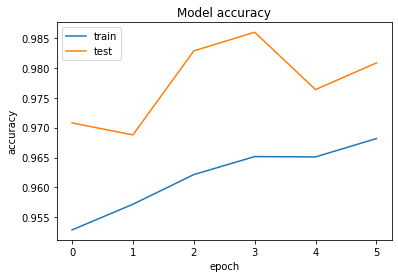

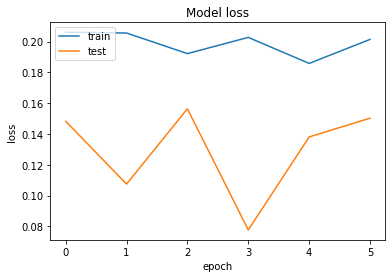

In [ ]:
plot_train_history(history_vgg)

In [ ]:

def test_model_and_submit(start=1, end=1, modelStr=''):
    img_rows, img_cols = 224, 224
    # batch_size = 64
    # random_state = 51
    nb_epoch = 15

    print('Start testing............')
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols,
                                                      color_type_global)
    yfull_test = []

    for index in range(start, end + 1):
        # Store test predictions
        model = read_model(index, modelStr)
        test_prediction = model.predict(test_data, batch_size=128, verbose=1)
        yfull_test.append(test_prediction)

    info_string = 'loss_' + modelStr \
                  + '_r_' + str(img_rows) \
                  + '_c_' + str(img_cols) \
                  + '_folds_' + str(end - start + 1) \
                  + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, end - start + 1)
    create_submission(test_res, test_id, info_string)

# nfolds, nb_epoch, split
run_cross_validation(2, 20, 0.15, '_vgg_16_2x20')

# nb_epoch, split
# run_one_fold_cross_validation(10, 0.1)

# test_model_and_submit(1, 10, 'high_epoch')